In [178]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

!pip install rapidfuzz

In [179]:
def data_file(file_path):
    return pd.read_excel(file_path)

In [180]:
data = data_file('raw_data_file.xlsx')

In [181]:
print(data.head(5))

   ID Fulfillment Status Accepts Marketing  Subtotal  Shipping  Taxes   Total  \
0   1          fulfilled                no    1999.0       0.0    0.0  1999.0   
1   2          fulfilled                no    1999.0       0.0    0.0  1999.0   
2   3          fulfilled               yes    1999.0       0.0    0.0  1999.0   
3   4          fulfilled               yes    1999.0       0.0    0.0  1999.0   
4   5          fulfilled               yes    1999.0       0.0    0.0  1999.0   

  Discount Code  Discount Amount Shipping Method  ... Billing City  \
0           NaN              0.0        Standard  ...    Bengaluru   
1           NaN              0.0        Standard  ...      Gurgaon   
2           NaN              0.0        Standard  ...    Bangalore   
3           NaN              0.0        Standard  ...   Bengaluru    
4           NaN              0.0        Standard  ...    BENGALURU   

   Billing Zip Billing Province  Shipping City  Shipping Zip  \
0      '560064              

In [182]:
def split_product_details(product):
    cleaned_product = re.sub(r'\[.*?\]', '', product).strip()
    parts = cleaned_product.split(' - ')

    # Extract Product Name, Color, and Product Code
    product_name = parts[0]
    color = parts[1] if len(parts) > 2 else None  # Second part is color (if present)
    product_code = parts[-1]  # Last part is the product code

    # Further split product code into size and code (e.g., "L-una" -> "L", "una")
    size = product_code.split('-')[0] if '-' in product_code else None
    code = product_code.split('-')[1] if '-' in product_code else None

    return pd.Series([product_name, color, size, code])

# Apply function to split the 'Product' column
data[['Product Name', 'Color', 'Size', 'Product Code']] = data['Product'].apply(split_product_details)
print(data)

            ID Fulfillment Status Accepts Marketing  Subtotal  Shipping  \
0            1          fulfilled                no    1999.0       0.0   
1            2          fulfilled                no    1999.0       0.0   
2            3          fulfilled               yes    1999.0       0.0   
3            4          fulfilled               yes    1999.0       0.0   
4            5          fulfilled               yes    1999.0       0.0   
...        ...                ...               ...       ...       ...   
135067  135068        unfulfilled                no    1999.0       0.0   
135068  135069        unfulfilled               yes    1999.0       0.0   
135069  135070        unfulfilled               yes    1999.0       0.0   
135070  135071        unfulfilled                no    1999.0       0.0   
135071  135072        unfulfilled               yes    1999.0       0.0   

         Taxes   Total Discount Code  Discount Amount Shipping Method  ...  \
0         0.00  1999.

In [183]:
data['Created Date'] = pd.to_datetime(data['Created Date'], format='%m/%d/%Y')
data['Week'] = data['Created Date'].dt.isocalendar().week
data['Week Start Date'] = (data['Created Date'] - pd.to_timedelta(data['Created Date'].dt.weekday, unit='d')).dt.date

In [184]:
data['Billing City'] = data['Billing City'].str.lower()
def billing_city(city):
  if isinstance(city, str):
    city = re.sub(r'[^a-zA-Z\s\-]', '', city)
    city = re.sub(r'\s+', ' ', city).strip()
    # city = city.split(',')[-1].strip()
  else:
     return None

  return city

data['Billing City'] = data['Billing City'].apply(billing_city)

city_mapping = {
    'bangalore': 'bengaluru',
    'calcutta': 'kolkata',
    'vishakhapatnam': 'vizag',
}
data['Billing City'] = data['Billing City'].replace(city_mapping).str.strip()
top_20_cities = data['Billing City'].value_counts().head(20).index.tolist()

from rapidfuzz import process

def fuzzy_correct_city(city):
    if city is None:  # Handle None values
        return None
    result = process.extractOne(city, top_20_cities)
    if result:  # Ensure a match is found
        match = result[0]  # The best-matched city name
        score = result[1]  # The confidence score
        return match if score > 80 else city
    return city  # Return the original cit


data['Billing City'] = data['Billing City'].apply(fuzzy_correct_city)

print(data['Billing City'].value_counts())

Billing City
mumbai            27136
bengaluru         17312
new delhi          7440
pune               6880
hyderabad          6464
                  ...  
likabali             16
uttarakhand          16
raiganj              16
mira bhayander       16
dharapuram           16
Name: count, Length: 463, dtype: int64


In [185]:
# Get unique values of each column
unique_values = data.apply(pd.Series.unique)
print(unique_values)

ID                             [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
Fulfillment Status                                 [fulfilled, unfulfilled, nan]
Accepts Marketing                                                 [no, yes, nan]
Subtotal                       [1999.0, 1899.0, 3998.0, nan, 7996.0, 0.0, 599...
Shipping                                                              [0.0, nan]
Taxes                          [0.0, nan, 239.88, 856.71, 214.18, 428.36, 642...
Total                          [1999.0, 1899.0, 3998.0, nan, 2238.88, 7996.0,...
Discount Code                  [nan, C201108-DL4MNP2, C201108-WQJLQT2, C20110...
Discount Amount                         [0.0, 100.0, nan, 1999.0, 200.0, 3998.0]
Shipping Method                                                  [Standard, nan]
Created Date                   [2020-12-05 00:00:00, 2020-12-06 00:00:00, 202...
Lineitem quantity                                                [1, 2, 3, 4, 5]
Product                     

In [186]:
result = data.groupby(['Week Start Date', 'Fulfillment Status']).size().unstack(fill_value=0)

# Step 4: Count the NaN values separately
nan_count = data[data['Fulfillment Status'].isna()].groupby('Week Start Date').size()

# Add the NaN counts to the result
result['NaN'] = nan_count
result = result.fillna(0).astype(int)  # Ensure integer counts

print(result)

Fulfillment Status  fulfilled  unfulfilled   NaN
Week Start Date                                 
2020-11-30                144            0     0
2020-12-07               1120           16    16
2020-12-14               1760           16     0
2020-12-21                176            0     0
2020-12-28                112            0     0
2021-01-04                400           48    16
2021-01-11                176           48    48
2021-01-18               1104           48    16
2021-01-25               2480           48    32
2021-02-01               1984           96    16
2021-02-08               2720           64     0
2021-02-15               3088           80    64
2021-02-22               2400          160    32
2021-03-01               3168           80    16
2021-03-08               3072           96    32
2021-03-15               3904           16    64
2021-03-22               3392           48    48
2021-03-29               3056           64    80
2021-04-05          

In [187]:
weekly_product_trends = data.groupby(
    ['Week Start Date', 'Product Code', 'Color', 'Size', 'Billing City']
)['Total'].sum().reset_index()

top_cities = weekly_product_trends.groupby('Billing City')['Total'].sum().nlargest(10).index
top_city_data = weekly_product_trends[weekly_product_trends['Billing City'].isin(top_cities)]

print(top_cities)
print(top_city_data.head(20))


Index(['mumbai', 'bengaluru', 'hyderabad', 'new delhi', 'pune', 'delhi',
       'ahmedabad', 'chennai', 'gurgaon', 'gurugram'],
      dtype='object', name='Billing City')
   Week Start Date Product Code     Color Size Billing City     Total
1       2021-06-14          aia     Black    M    bengaluru  383808.0
4       2021-06-14          aia     Black    M      chennai   95952.0
5       2021-06-14          aia     Black    M        delhi   95952.0
7       2021-06-14          aia     Black    M      gurgaon   86352.0
8       2021-06-14          aia     Black    M     gurugram  287856.0
9       2021-06-14          aia     Black    M    hyderabad   95952.0
13      2021-06-14          aia     Black    M       mumbai  566112.0
16      2021-06-14          aia     Black    M    new delhi  191904.0
17      2021-06-14          aia     Black    M         pune  287856.0
18      2021-06-14          aia  Burgundy    M    bengaluru  287856.0
19      2021-06-14          aia  Burgundy    M      gurgaon

<ipython-input-222-fa0ad50104dd>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Total', y='Billing City', data=city_revenue, palette='viridis')


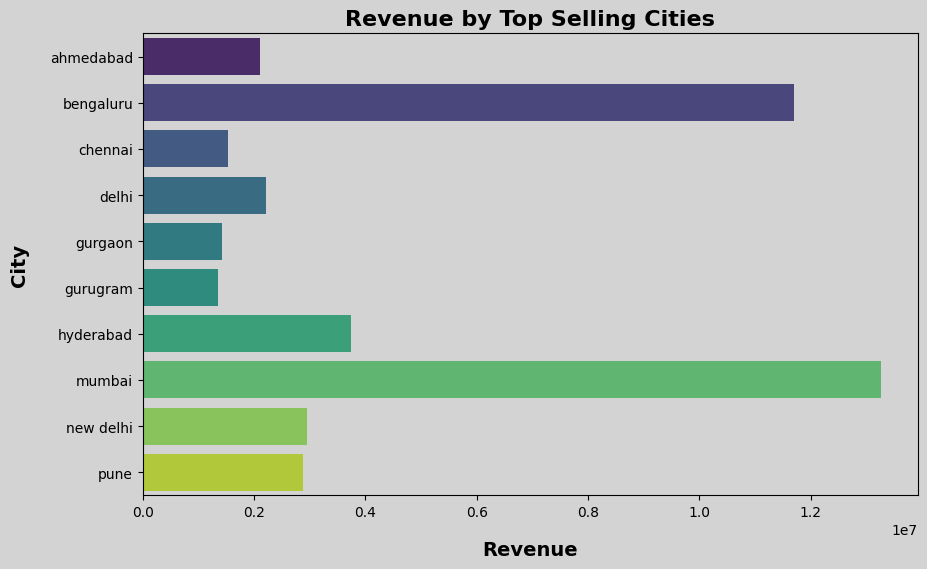

In [222]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sum the revenue by city
city_revenue = top_city_data.groupby('Billing City')['Total'].sum().reset_index()

# Plot revenue vs top cities
plt.figure(figsize=(10, 6), facecolor='lightgrey')  # Set light grey background for the figure
ax = sns.barplot(x='Total', y='Billing City', data=city_revenue, palette='viridis')

# Customize the plot
plt.title('Revenue by Top Selling Cities', fontsize=16, weight='bold')
plt.xlabel('Revenue', fontsize=14, weight='bold', labelpad=15)
plt.ylabel('City', fontsize=14, weight='bold', labelpad=15)

# Set light grey background for the plot area
ax.set_facecolor('lightgrey')

plt.show()




<ipython-input-214-9f103c5cdf31>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Total', y='Size', data=size_revenue, palette='coolwarm')


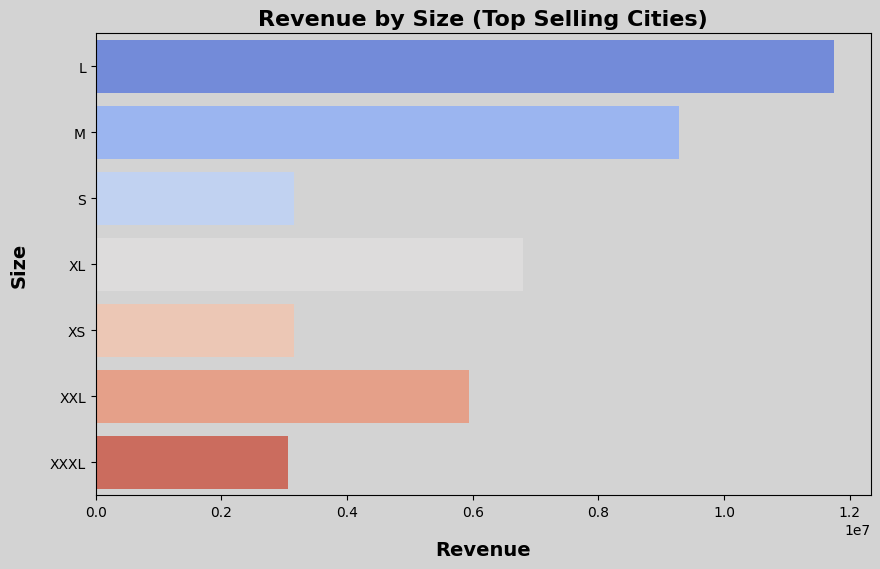

In [214]:
# Sum the revenue by size for top cities
size_revenue = top_city_data.groupby('Size')['Total'].sum().reset_index()

# Plot revenue vs size
plt.figure(figsize=(10, 6), facecolor='lightgrey')  # Set light grey background for the figure
ax = sns.barplot(x='Total', y='Size', data=size_revenue, palette='coolwarm')

# Customize plot
plt.title('Revenue by Size (Top Selling Cities)', fontsize=16, weight='bold')
plt.xlabel('Revenue', fontsize=14, weight='bold', labelpad=15)
plt.ylabel('Size', fontsize=14, weight='bold', labelpad=15)

# Set light grey for the plot background as well
ax.set_facecolor('lightgrey')

plt.show()


<ipython-input-213-d63abcab6241>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Total', y='Color', data=color_revenue, palette='muted')


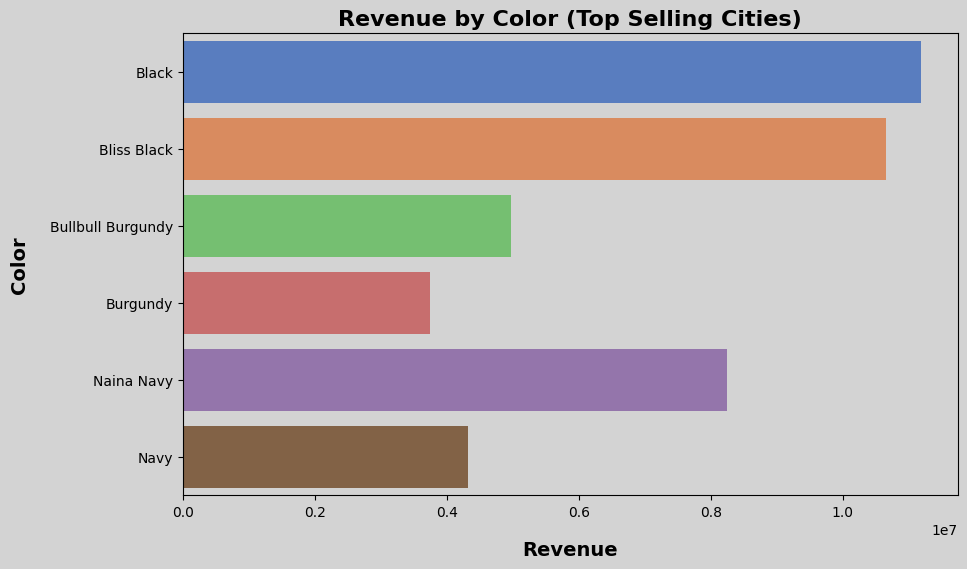

In [213]:
# Sum the revenue by color for top cities
color_revenue = top_city_data.groupby('Color')['Total'].sum().reset_index()

# Plot revenue vs color
plt.figure(figsize=(10, 6), facecolor='lightgrey')  # Set light grey background for the figure
ax = sns.barplot(x='Total', y='Color', data=color_revenue, palette='muted')

# Customize plot
plt.title('Revenue by Color (Top Selling Cities)', fontsize=16, weight='bold')
plt.xlabel('Revenue', fontsize=14, weight='bold', labelpad=15)
plt.ylabel('Color', fontsize=14, weight='bold', labelpad=15)

# Customize axes
ax.set_facecolor('lightgrey')  # Set the inner plot background to light grey
plt.show()


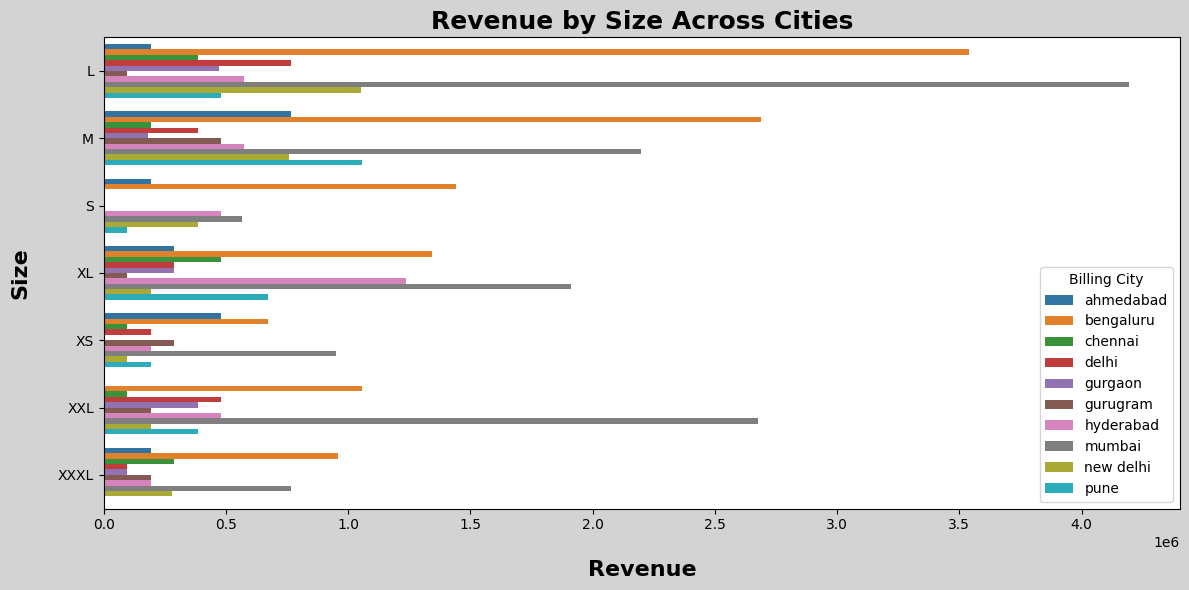

In [227]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'top_city_data' is already defined

# Sum the revenue by size and city
size_revenue = top_city_data.groupby(['Size', 'Billing City'])['Total'].sum().reset_index()

# Create the plot with a light grey background
plt.figure(figsize=(12, 6), facecolor='lightgrey')  # Set light grey background for the figure

# Plot revenue by size and city with hue for city
sns.barplot(x='Total', y='Size', hue='Billing City', data=size_revenue)

# Customizing the plot
plt.title('Revenue by Size Across Cities', fontsize=18, fontweight='bold')  # Title size increased and bold
plt.xlabel('Revenue', fontsize=16, labelpad=20, fontweight='bold')  # x-axis label size increased and bold
plt.ylabel('Size', fontsize=16, labelpad=20, fontweight='bold')  # y-axis label size increased and bold

# Show the plot
plt.tight_layout()  # Ensure the labels don't overlap
plt.show()


In [192]:
data.isnull().sum()

,0
ID,0
Fulfillment Status,4992
Accepts Marketing,4992
Subtotal,4992
Shipping,4992
Taxes,4992
Total,4992
Discount Code,129696
Discount Amount,4992
Shipping Method,10800


In [193]:
data['Shipping Zip'] = data['Shipping Zip'].str.extract('(\d+)')
pincode_counts = data['Shipping Zip'].value_counts().sort_values(ascending=False).head(20)

print(pincode_counts)

Shipping Zip
122002    1856
400050    1792
400053    1312
560037    1280
395007    1056
400063    1040
400052    1024
400058     944
380015     928
560078     912
400049     912
122001     896
201301     896
400006     864
400071     816
560103     816
560038     800
560034     800
110034     768
500034     768
Name: count, dtype: int64


In [194]:
result = data.groupby('Shipping Zip')['Total'].sum().reset_index()
result = result.sort_values(by='Total', ascending=False)

top_20_pincodes = result.head(20)
print(top_20_pincodes)

    Shipping Zip      Total
81        122002  4116336.0
441       400050  3918032.0
444       400053  2718640.0
818       560037  2398800.0
453       400063  2302848.0
443       400052  2293248.0
870       560103  2109344.0
349       380015  2046976.0
851       560078  2014992.0
440       400049  1983008.0
80        122001  1951024.0
393       395007  1917440.0
199       201301  1887056.0
869       560102  1885456.0
815       560034  1823088.0
447       400056  1791104.0
449       400058  1762304.0
461       400071  1759120.0
409       400006  1727136.0
819       560038  1631184.0


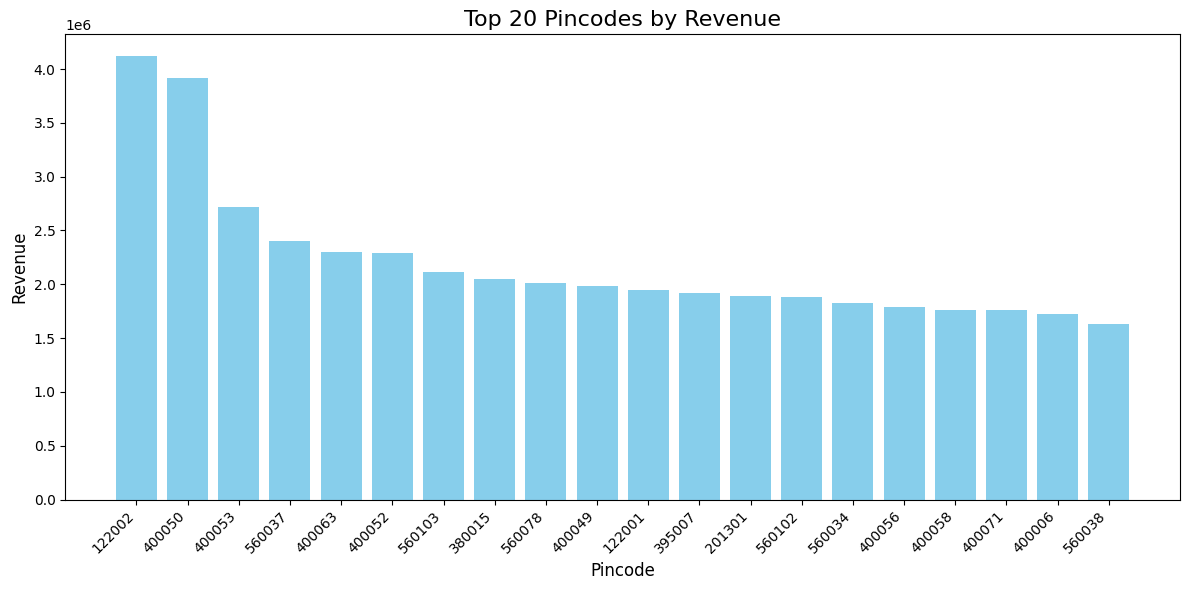

In [195]:
plt.figure(figsize=(12, 6))
plt.bar(top_20_pincodes['Shipping Zip'].astype(str), top_20_pincodes['Total'], color='skyblue')
plt.title('Top 20 Pincodes by Revenue', fontsize=16)
plt.xlabel('Pincode', fontsize=12)
plt.ylabel('Revenue', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

In [196]:
print(data.dtypes)

ID                                      int64
Fulfillment Status                     object
Accepts Marketing                      object
Subtotal                              float64
Shipping                              float64
Taxes                                 float64
Total                                 float64
Discount Code                          object
Discount Amount                       float64
Shipping Method                        object
Created Date                   datetime64[ns]
Lineitem quantity                       int64
Product                                object
Lineitem price                          int64
Lineitem compare at price             float64
Lineitem sku                          float64
Lineitem requires shipping               bool
Lineitem taxable                         bool
Lineitem fulfillment status            object
Billing City                           object
Billing Zip                            object
Billing Province                  

In [197]:
def segment_revenue_by_week(dataframe, date_column, revenue_column):
    """
    Segments revenue by week using the Created Date and calculates week-over-week percentage changes.

    Parameters:
        dataframe (pd.DataFrame): Input DataFrame containing the data.
        date_column (str): The name of the date column (e.g., "Created Date").
        revenue_column (str): The name of the revenue column (e.g., "Total").

    Returns:
        pd.DataFrame: A DataFrame with weekly revenue and week-over-week percentage changes.
    """
    # Group by week (using the start of each week as the label)
    dataframe['Week'] = dataframe[date_column].dt.to_period('W').apply(lambda r: r.start_time)
    weekly_revenue = dataframe.groupby('Week')[revenue_column].sum().reset_index()

    # Calculate week-over-week percentage changes
    weekly_revenue['WoW Change (%)'] = weekly_revenue[revenue_column].pct_change() * 100

    return weekly_revenue

In [198]:
weekly_revenue = segment_revenue_by_week(data,"Created Date","Total")
print(weekly_revenue)

         Week        Total  WoW Change (%)
0  2020-11-30    287856.00             NaN
1  2020-12-07   2299648.00      698.888333
2  2020-12-14   3706944.00       61.196148
3  2020-12-21    382208.00      -89.689405
4  2020-12-28    223888.00      -41.422472
5  2021-01-04    925936.00      313.571071
6  2021-01-11    579550.08      -37.409272
7  2021-01-18   2366816.00      308.388521
8  2021-01-25   5245376.00      121.621622
9  2021-02-01   4218688.00      -19.573201
10 2021-02-08   5725136.00       35.708922
11 2021-02-15   6516736.00       13.826746
12 2021-02-22   5243776.00      -19.533705
13 2021-03-01   6906944.00       31.716992
14 2021-03-08   6555120.00       -5.093772
15 2021-03-15   8247072.00       25.811152
16 2021-03-22   7129232.00      -13.554386
17 2021-03-29   6585504.00       -7.626740
18 2021-04-05   3646176.00      -44.633304
19 2021-04-12   2622688.00      -28.070175
20 2021-04-19   4925536.00       87.804878
21 2021-04-26   6716640.00       36.363636
22 2021-05-

In [225]:
import matplotlib.pyplot as plt

def plot_revenue_trends(weekly_revenue, week_column, revenue_column):
    """
    Plots weekly revenue and highlights spikes or drops in revenue.

    Parameters:
        weekly_revenue (pd.DataFrame): DataFrame with weekly data.
        week_column (str): The name of the week column (e.g., "Week").
        revenue_column (str): The name of the revenue column (e.g., "Total").
    """
    # Create the plot with light grey background
    plt.figure(figsize=(12, 6), facecolor='lightgrey')  # Set light grey background for the figure

    # Plot weekly revenue
    plt.plot(weekly_revenue[week_column], weekly_revenue[revenue_column], marker='o', label='Weekly Revenue', color='blue')

    # Mark specific dates on the x-axis (you can adjust this list)
    specific_dates = weekly_revenue[week_column][::5]  # Mark every 5th date for example
    plt.xticks(specific_dates)

    # Labels and legends with increased font size and bold text
    plt.title('Weekly Revenue', fontsize=18, weight='bold')  # Title size increased and bold
    plt.xlabel('Week', fontsize=16, labelpad=20, fontweight='bold')  # x-axis label size increased and bold
    plt.ylabel('Revenue', fontsize=16, labelpad=20, fontweight='bold')  # y-axis label size increased and bold
    plt.legend(fontsize=16, title='Legend', title_fontsize=18)  # Increased font size for legend

    # Ensure tight layout for better spacing
    plt.tight_layout()

    # Show the plot without grid
    plt.show()

# Example usage (assuming you have the 'weekly_revenue' DataFrame ready)
# plot_revenue_trends(weekly_revenue, 'Week', 'Total')


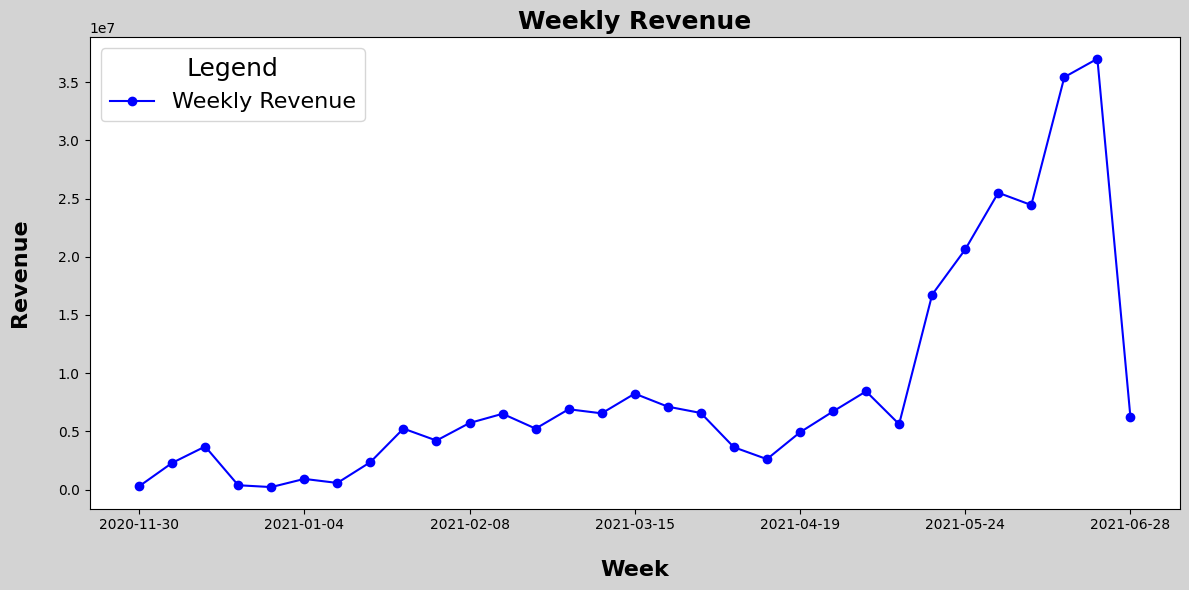

In [226]:
plot_revenue_trends(weekly_revenue,"Week","Total")